In [1]:
import numpy as np
import random
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch
import time
from time import gmtime, strftime
import os
from pytorch_lightning import seed_everything
from data.data_split import cyclic_split
from data.dataset import get_dataset_class,CustomTensorDataset_GBA_seq_gap, CustomTensorDataset_GBA_seq
from data.transforms import ClassifyByThresholds
from trainer import NIMSTrainer_Germnay_Two
from model.swinunet_model import SwinUnet_CAM_Two
from model.conv_lstm import ConvLSTM,ConvLSTM_Two
from losses import *
from utils import *
import torch.optim as optim
import warnings
import sys
import datetime
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

import wandb

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda')
seed_everything(11611801)
g = torch.Generator()
g.manual_seed(11611801)


# Set experiment name and use it as process name if possible
# print('Running Experiment'.center(30).center(80, "="))
# print(experiment_name)

save_path = '/home/jianer/github_proj/PostRainBenchTest-main/3_GBA_wandb_ConvLSTM/GBA_dataset/experiment/'
trn_x_1 = np.load(save_path + 'X_train_period1.npy')
trn_x_2= np.load(save_path + 'X_train_period2.npy')
trn_y_1 = np.load(save_path + 'y_train_period1.npy')
trn_y_2 = np.load(save_path + 'y_train_period2.npy')

tst_x = np.load(save_path + 'X_test_period.npy')
tst_y = np.load(save_path + 'y_test_period.npy')
vld_x = np.load(save_path + 'X_valid_period.npy')
vld_y = np.load(save_path + 'y_valid_period.npy')

print('Load datasets in CPU memory successfully!')
print("#" * 80)
rain_thresholds = [0.4, 52, 100]
seq_length = 1
kernel_size = 3
num_layers = 3
batch_size = 100
num_classes = 4
input_data = 'gdaps_kim'
train_dataset = CustomTensorDataset_GBA_seq_gap(torch.from_numpy(trn_x_1),torch.from_numpy(trn_x_2), \
                                                torch.from_numpy(trn_y_1), torch.from_numpy(trn_y_2), \
                                                rain_thresholds, sequence_length=seq_length, downscaling_t=4)
val_dataset = CustomTensorDataset_GBA_seq(torch.from_numpy(vld_x),torch.from_numpy(vld_y), rain_thresholds, sequence_length=seq_length, downscaling_t=4)
test_dataset = CustomTensorDataset_GBA_seq(torch.from_numpy(tst_x),torch.from_numpy(tst_y), rain_thresholds, sequence_length=seq_length, downscaling_t=4)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
for x, y, z in train_dataset:
    print(f'x shape: {x.shape}')
    print(f'y shape: {y.shape}')
    print(f'z shape: {z.shape}')
    break  # 打印一次后跳出循环
for x, y, z in train_loader:
    print(f'x shape: {x.shape}')
    print(f'y shape: {y.shape}')
    print(f'z shape: {z.shape}')
    break  # 打印一次后跳出循环


Global seed set to 11611801


Load datasets in CPU memory successfully!
################################################################################
x shape: torch.Size([4, 84, 64, 64])
y shape: torch.Size([1, 64, 64])
z shape: torch.Size([1, 64, 64])
x shape: torch.Size([100, 4, 84, 64, 64])
y shape: torch.Size([100, 1, 64, 64])
z shape: torch.Size([100, 1, 64, 64])


In [96]:
nwp_sample = torch.rand(1, 1, 84, 64, 64)
# set model
model = ConvLSTM_Two(input_data=input_data,
                        window_size=1,
                        input_dim=nwp_sample.shape[2],
                        hidden_dim=16,
                        kernel_size=(kernel_size,kernel_size),  # hotfix: only supports single tuple of size 2
                        num_layers=num_layers,
                        num_classes=num_classes,
                        batch_first=True,
                        bias=True,
                        return_all_layers=False)
epoch = '067'
# experiment = 'PRBenchTest_ConvLSTM_GBA_2015_2022_2024-11-13181128'
experiment = 'PRBenchTest_ConvLSTM_GBA_2015_2022_2024-11-06-161441'
model_path = f'/home/jianer/github_proj/PostRainBenchTest-main/3_GBA_wandb_ConvLSTM/output/{experiment}/trained_model/epoch{epoch}.pt'
# if finetune:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'], strict=True)
print('Load model successfully!')

Load model successfully!


In [97]:
model.to(device)

ConvLSTM_Two(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(100, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
  )
  (out_conv): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))


In [98]:
# 初始化用于存储结果的列表
all_predict_cls = []
all_predict_reg = []
all_target_cls = []
all_target_reg = []


for i, (images, target_cls, target_reg) in enumerate(train_loader):
    images = images.type(torch.FloatTensor).to(device)
    target_cls = target_cls.type(torch.LongTensor).to(device)
    target_reg = target_reg.type(torch.LongTensor).to(device)

    # 获取模型输出
    output, output2 = model(images, target_reg)
    _, predict_cls = output.detach().cpu().topk(1, dim=1, largest=True, sorted=True)  # (batch_size, height, width)
    predict_reg = output2
    # predict_reg = F.relu(output2)
    
    # 将每个 batch 的结果添加到列表
    all_predict_cls.append(predict_cls.numpy())
    all_target_cls.append(target_cls.detach().cpu().numpy())
    all_predict_reg.append(predict_reg.detach().cpu().numpy())
    all_target_reg.append(target_reg.detach().cpu().numpy())


# 将所有 batch 的结果合并为单个 numpy array
train_predict_cls = np.concatenate(all_predict_cls, axis=0).squeeze(1)
train_target_cls = np.concatenate(all_target_cls, axis=0).squeeze(1)
train_predict_reg = np.concatenate(all_predict_reg, axis=0).squeeze(1)
train_target_reg = np.concatenate(all_target_reg, axis=0).squeeze(1)

In [99]:
print(train_predict_cls.shape)
print(train_target_cls.shape)
print(train_predict_reg.shape)
print(train_target_reg.shape)

(1947, 64, 64)
(1947, 64, 64)
(1947, 64, 64)
(1947, 64, 64)


In [100]:
# 初始化用于存储结果的列表
all_predict_cls = []
all_predict_reg = []
all_target_cls = []
all_target_reg = []


for i, (images, target_cls, target_reg) in enumerate(valid_loader):
    images = images.type(torch.FloatTensor).to(device)
    target_cls = target_cls.type(torch.LongTensor).to(device)
    target_reg = target_reg.type(torch.LongTensor).to(device)

    # 获取模型输出
    output, output2 = model(images, target_reg)
    _, predict_cls = output.detach().cpu().topk(1, dim=1, largest=True, sorted=True)  # (batch_size, height, width)
    predict_reg = output2
    # predict_reg = F.relu(output2)
    
    # 将每个 batch 的结果添加到列表
    all_predict_cls.append(predict_cls.numpy())
    all_target_cls.append(target_cls.detach().cpu().numpy())
    all_predict_reg.append(predict_reg.detach().cpu().numpy())
    all_target_reg.append(target_reg.detach().cpu().numpy())


valid_predict_cls = np.concatenate(all_predict_cls, axis=0).squeeze(1)
valid_target_cls = np.concatenate(all_target_cls, axis=0).squeeze(1)
valid_predict_reg = np.concatenate(all_predict_reg, axis=0).squeeze(1)
valid_target_reg = np.concatenate(all_target_reg, axis=0).squeeze(1)

In [101]:
print(valid_predict_cls.shape)
print(valid_target_cls.shape)
print(valid_predict_reg.shape)
print(valid_target_reg.shape)

(365, 64, 64)
(365, 64, 64)
(365, 64, 64)
(365, 64, 64)


In [102]:
# 初始化用于存储结果的列表
all_predict_cls = []
all_predict_reg = []
all_target_cls = []
all_target_reg = []


for i, (images, target_cls, target_reg) in enumerate(test_loader):
    images = images.type(torch.FloatTensor).to(device)
    target_cls = target_cls.type(torch.LongTensor).to(device)
    target_reg = target_reg.type(torch.LongTensor).to(device)

    # 获取模型输出
    output, output2 = model(images, target_reg)
    _, predict_cls = output.detach().cpu().topk(1, dim=1, largest=True, sorted=True)  # (batch_size, height, width)
    predict_reg = output2
    # predict_reg = F.relu(output2)
    
    # 将每个 batch 的结果添加到列表
    all_predict_cls.append(predict_cls.numpy())
    all_target_cls.append(target_cls.detach().cpu().numpy())
    all_predict_reg.append(predict_reg.detach().cpu().numpy())
    all_target_reg.append(target_reg.detach().cpu().numpy())


# 将所有 batch 的结果合并为单个 numpy array
test_predict_cls = np.concatenate(all_predict_cls, axis=0).squeeze(1)
test_target_cls = np.concatenate(all_target_cls, axis=0).squeeze(1)
test_predict_reg = np.concatenate(all_predict_reg, axis=0).squeeze(1)
test_target_reg = np.concatenate(all_target_reg, axis=0).squeeze(1)

In [103]:
print(test_predict_cls.shape)
print(test_target_cls.shape)
print(test_predict_reg.shape)
print(test_target_reg.shape)

(365, 64, 64)
(365, 64, 64)
(365, 64, 64)
(365, 64, 64)


In [104]:
from datetime import datetime

def count_days_between(date1, date2):
# 将字符串转换为日期对象
    start_date = datetime.strptime(date1, '%Y-%m-%d')
    end_date = datetime.strptime(date2, '%Y-%m-%d')

    # 计算天数
    delta = end_date - start_date
    return delta.days

# 示例使用
days = count_days_between('2018-01-01', '2018-06-08')
print(f"从1961年到2017年之间有 {days} 天。")
days = count_days_between('2022-01-01', '2022-05-10')
print(f"从2018年到2023年之间有 {days} 天。")

从1961年到2017年之间有 158 天。
从2018年到2023年之间有 129 天。


In [105]:
import matplotlib.pyplot as plt

# 选择要显示的样本索引
sample_index = 158

# 获取四个矩阵的第 sample_index 个样本
sample_predict_cls = valid_predict_cls[sample_index]
sample_target_cls = valid_target_cls[sample_index]
sample_predict_reg = valid_predict_reg[sample_index]
sample_target_reg = valid_target_reg[sample_index]

mask = (sample_target_cls>=0)

# 使用 np.nan 替换 mask 为 False 的位置
sample_predict_cls = np.where(mask, sample_predict_cls, np.nan)
sample_target_cls = np.where(mask, sample_target_cls, np.nan)
sample_predict_reg = np.where(mask, sample_predict_reg, np.nan)
sample_target_reg = np.where(mask, sample_target_reg, np.nan)

# print(sample_predict_cls)
# print(sample_target_cls)
# print(sample_predict_reg)
# print(sample_target_reg)

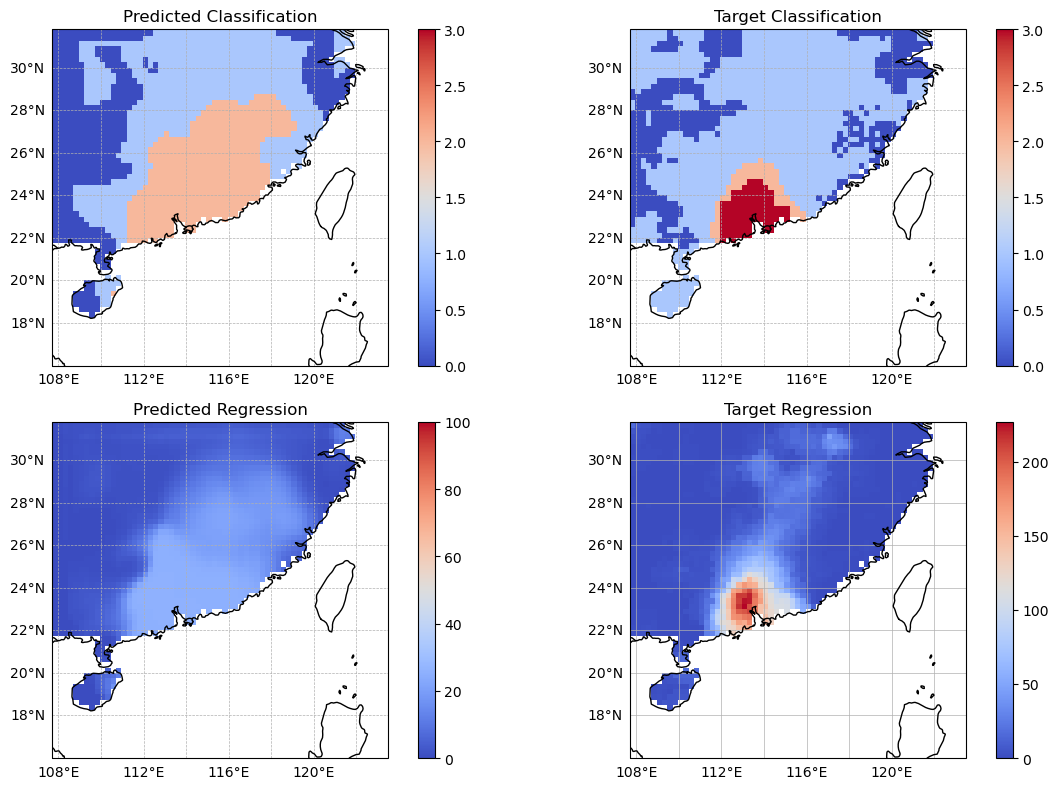

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the longitude and latitude ranges
lon_min = 107.7
lon_max = 123.5
lat_min = 16
lat_max = 31.8

# Define the spatial resolution (0.25°)
resolution = 0.25

# Generate the longitude and latitude subsets
lon_subset = np.arange(lon_min, lon_max + resolution, resolution)
lat_subset = np.arange(lat_min, lat_max + resolution, resolution)

# Create grid for plotting
lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

# Set up the plot
plt.figure(figsize=(12, 8))

# 1. Predicted Classification
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
# Plot classification
pc1 = ax1.pcolormesh(lon_grid, lat_grid, sample_predict_cls, cmap='coolwarm', shading='auto', vmin=0, vmax=3)
ax1.set_title('Predicted Classification')
# Draw gridlines behind the plot with thinner, dashed gridlines
gl1 = ax1.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, zorder=1)
gl1.top_labels = False  # 不显示顶部标签
gl1.right_labels = False  # 不显示右侧标签
# Add colorbar for predicted classification
plt.colorbar(pc1, ax=ax1, orientation='vertical')

# 2. Target Classification
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
# Plot classification
pc2 = ax2.pcolormesh(lon_grid, lat_grid, sample_target_cls, cmap='coolwarm', shading='auto', vmin=0, vmax=3)
ax2.set_title('Target Classification')
# Draw gridlines behind the plot with thinner, dashed gridlines
gl2 = ax2.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, zorder=1)
gl2.top_labels = False  # 不显示顶部标签
gl2.right_labels = False  # 不显示右侧标签
# Add colorbar for target classification
plt.colorbar(pc2, ax=ax2, orientation='vertical')

# 3. Predicted Regression
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS)
# Plot regression
pc3 = ax3.pcolormesh(lon_grid, lat_grid, sample_predict_reg, cmap='coolwarm', shading='auto', vmin=0, vmax=100)
ax3.set_title('Predicted Regression')
# Draw gridlines behind the plot with thinner, dashed gridlines
gl3 = ax3.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, zorder=1)
gl3.top_labels = False  # 不显示顶部标签
gl3.right_labels = False  # 不显示右侧标签
# Add colorbar for predicted regression
plt.colorbar(pc3, ax=ax3, orientation='vertical')

# 4. Target Regression
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS)
# Plot regression
pc4 = ax4.pcolormesh(lon_grid, lat_grid, sample_target_reg, cmap='coolwarm', shading='auto')
ax4.set_title('Target Regression')
# Draw gridlines behind the plot with thinner, dashed gridlines
gl4 = ax4.gridlines(draw_labels=True, linestyle='---', linewidth=0.5, zorder=1)
gl4.top_labels = False  # 不显示顶部标签
gl4.right_labels = False  # 不显示右侧标签
# Add colorbar for target regression
plt.colorbar(pc4, ax=ax4, orientation='vertical')

plt.tight_layout()
plt.savefig(f'{sample_index}-{experiment}.png', transparent=True)
plt.show()

In [107]:
def ClassifyByThresholds(thresholds, grid):
    """
    Map AWS observation values to one-hot vectors according to `thresholds`.
    """

    thresholds = [0.0] + thresholds + [float('inf')]
    # Initialize the result array with NaN (for unclassified regions)
    result = np.full(grid.shape, np.nan)
    
    # Create a mask for non-NaN values
    nan_mask = np.isnan(grid)
    print(np.isnan(grid).sum())
    print(np.isnan(result).sum())
    # Classify values based on the thresholds, ignoring NaN
    for i, start in enumerate(thresholds[:-1]):
        end = thresholds[i + 1]
        result = np.where((~nan_mask) & (start <= grid) & (grid < end), int(i), result)

    print(np.isnan(grid).sum())
    print(np.isnan(result).sum())
    
    # Flatten the result array to 1D for label counting
    result_classified_flat = result.ravel()
    
    # Count the occurrences of each label (class), excluding NaNs
    valid_values = result_classified_flat[~np.isnan(result_classified_flat)].astype(int)
    label_counts = np.bincount(valid_values)

    # Return the result and label counts
    return result, label_counts

In [108]:
thresholds = [0.4, 52, 100]  # Adjust these values based on your data range

nan_mask = np.isnan(sample_predict_reg)
# 
classified_sample_reg, label_counts = ClassifyByThresholds(thresholds, sample_predict_reg)

print(label_counts)

classified_sample_reg[nan_mask] = np.nan  # Or you can use a specific integer like -1 to indicate NaN

2135
4096
2135
2285
[  59 1752]


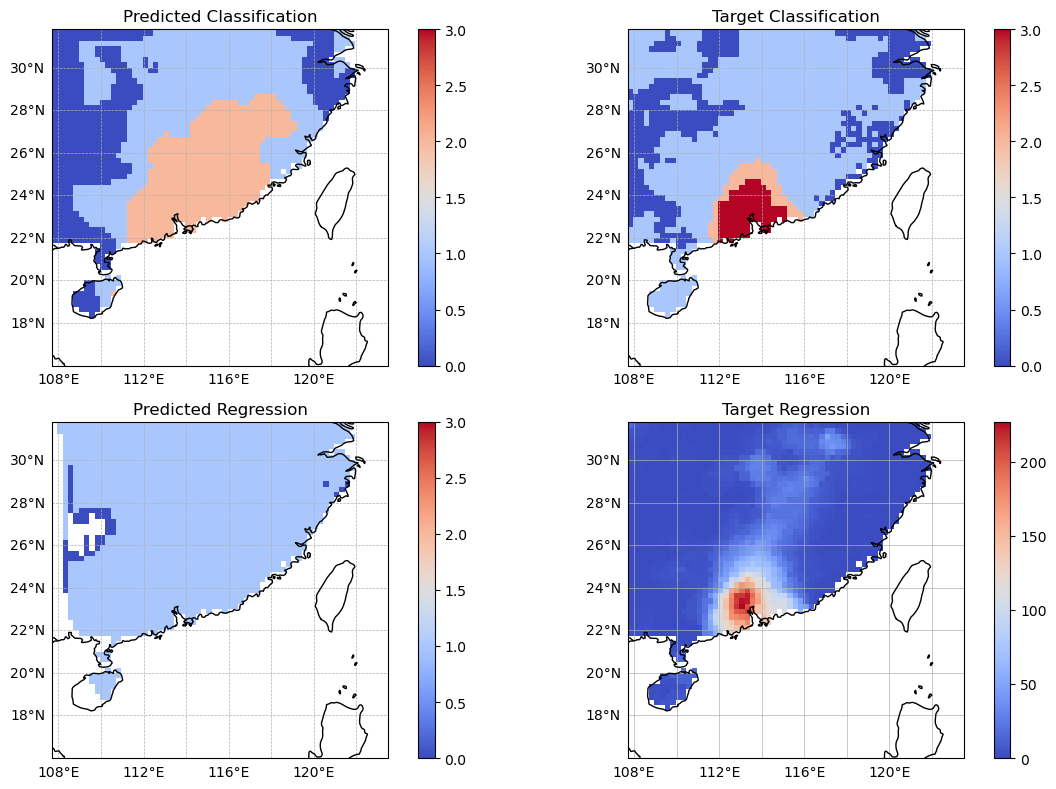

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define the longitude and latitude ranges
lon_min = 107.7
lon_max = 123.5
lat_min = 16
lat_max = 31.8

# Define the spatial resolution (0.25°)
resolution = 0.25

# Generate the longitude and latitude subsets
lon_subset = np.arange(lon_min, lon_max + resolution, resolution)
lat_subset = np.arange(lat_min, lat_max + resolution, resolution)

# Create grid for plotting
lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

# Set up the plot
plt.figure(figsize=(12, 8))

# 1. Predicted Classification
ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS)
# Plot classification
pc1 = ax1.pcolormesh(lon_grid, lat_grid, sample_predict_cls, cmap='coolwarm', shading='auto', vmin=0, vmax=3)
ax1.set_title('Predicted Classification')
# Draw gridlines behind the plot with thinner, dashed gridlines
gl1 = ax1.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, zorder=1)
gl1.top_labels = False  # 不显示顶部标签
gl1.right_labels = False  # 不显示右侧标签
# Add colorbar for predicted classification
plt.colorbar(pc1, ax=ax1, orientation='vertical')

# 2. Target Classification
ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS)
# Plot classification
pc2 = ax2.pcolormesh(lon_grid, lat_grid, sample_target_cls, cmap='coolwarm', shading='auto', vmin=0, vmax=3)
ax2.set_title('Target Classification')
# Draw gridlines behind the plot with thinner, dashed gridlines
gl2 = ax2.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, zorder=1)
gl2.top_labels = False  # 不显示顶部标签
gl2.right_labels = False  # 不显示右侧标签
# Add colorbar for target classification
plt.colorbar(pc2, ax=ax2, orientation='vertical')

# 3. Predicted Regression
ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax3.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE)
ax3.add_feature(cfeature.BORDERS)
# Plot regression
pc3 = ax3.pcolormesh(lon_grid, lat_grid, classified_sample_reg, cmap='coolwarm', shading='auto', vmin=0, vmax=3)
ax3.set_title('Predicted Regression')
# Draw gridlines behind the plot with thinner, dashed gridlines
gl3 = ax3.gridlines(draw_labels=True, linestyle='--', linewidth=0.5, zorder=1)
gl3.top_labels = False  # 不显示顶部标签
gl3.right_labels = False  # 不显示右侧标签
# Add colorbar for predicted regression
plt.colorbar(pc3, ax=ax3, orientation='vertical')

# 4. Target Regression
ax4 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax4.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE)
ax4.add_feature(cfeature.BORDERS)
# Plot regression
pc4 = ax4.pcolormesh(lon_grid, lat_grid, sample_target_reg, cmap='coolwarm', shading='auto')
ax4.set_title('Target Regression')
# Draw gridlines behind the plot with thinner, dashed gridlines
gl4 = ax4.gridlines(draw_labels=True, linestyle='---', linewidth=0.5, zorder=1)
gl4.top_labels = False  # 不显示顶部标签
gl4.right_labels = False  # 不显示右侧标签
# Add colorbar for target regression
plt.colorbar(pc4, ax=ax4, orientation='vertical')

plt.tight_layout()
plt.savefig(f'{sample_index}-{experiment}.png', transparent=True)
plt.show()